# My First ML Project - Creating a Model for Car Price Prediction

In this project, I practiced the basic workflow of Machine Learning. The model predicts the price of a car based on various features. The information about the [dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data) available [here](https://archive.ics.uci.edu/ml/datasets/automobile).

I used the k-nearest neighbors algorithm to build the model. Then, I evaluated the efficiency of the model. I used different types of validation techniques and metrics. 

The different techniques returned the same model parameters as the most efficient. But, the model needs further optimization based on the MAE/RMSE comparison.


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
import collections

columns = ['symboling', 'normalized_losses', 'make', 'fuel_type',
          'aspiration', 'num_doors', 'body_style', 'drive_wheels',
          'engine_location', 'wheel_base', 'length', 'width',
          'height', 'curb_weight', 'engine_type', 'num_cylinders',
          'engine_size', 'fuel_system', 'bore', 'stroke',
          'compression_ratio', 'horsepower', 'peak_rmp',
          'city_mpg', 'highway_mpg', 'price']

cars = pd.read_csv('imports-85.data', header=None, names=columns)

## Getting familiar with the data

In [11]:
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rmp,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


The following columns are numeric and can be used for analysis:
- normalized_losses;
- wheel_base;
- length;
- width;
- height;
- curb-weight;
- bore;
- stroke;
- compression-ratio;
- horsepower;
- peak-rpm;
- city-mpg;
- highway-mpg

The price is the target column. We can see that there are some '?' values in normalized_losses column. We will replace all such values to np.nan. 

## Data cleaning

In [12]:
# Replace '?' values witn np.nan
cars = cars.replace('?', np.nan)

# Check columns datatypes
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized_losses    164 non-null object
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
num_doors            203 non-null object
body_style           205 non-null object
drive_wheels         205 non-null object
engine_location      205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_type          205 non-null object
num_cylinders        205 non-null object
engine_size          205 non-null int64
fuel_system          205 non-null object
bore                 201 non-null object
stroke               201 non-null object
compression_ratio    205 non-null float64
horsepower           203 non-nul

We can see that some columns contain Nan values. We well drop rows where price is null as it's a predicted value. For all other columns, we will replace missing values with the mean of the particular column.

In [13]:
# Separate columns with numeric values
numeric_cols = ['normalized_losses', 'wheel_base', 'length', 'width',
          'height', 'curb_weight','bore', 'stroke',
          'compression_ratio', 'horsepower', 'peak_rmp',
          'city_mpg', 'highway_mpg', 'price']
cars_num = cars[numeric_cols]

# Drop columns where price is null
cars_num = cars_num.dropna(subset=['price'])

# Convert all columns to float data type
cars_num = cars_num.astype('float')

# Replace missing values with mean of the column
cars_num = cars_num.fillna(cars_num.mean())
print(cars_num.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 204
Data columns (total 14 columns):
normalized_losses    201 non-null float64
wheel_base           201 non-null float64
length               201 non-null float64
width                201 non-null float64
height               201 non-null float64
curb_weight          201 non-null float64
bore                 201 non-null float64
stroke               201 non-null float64
compression_ratio    201 non-null float64
horsepower           201 non-null float64
peak_rmp             201 non-null float64
city_mpg             201 non-null float64
highway_mpg          201 non-null float64
price                201 non-null float64
dtypes: float64(14)
memory usage: 23.6 KB
None


## Data normalization

The next step is to rescale our data to make the analysis consistent. For this project, we will normalize our data so all values range from 0 to 1. The price column won't be normalized.

In [14]:
# Normalize columns
price = cars_num['price']
cars_num = (cars_num - cars_num.min()) / (cars_num.max() - cars_num.min())
cars_num['price'] = price
cars_num.head(10)

,normalized_losses,wheel_base,length,width,height,curb_weight,bore,stroke,compression_ratio,horsepower,peak_rmp,city_mpg,highway_mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.664286,0.290476,0.12500,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.664286,0.290476,0.12500,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.100000,0.666667,0.12500,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.518325,0.384840,0.529851,0.504274,0.541667,0.329325,0.464286,0.633333,0.18750,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.518325,0.373178,0.529851,0.521368,0.541667,0.518231,0.464286,0.633333,0.06250,0.313084,0.551020,0.138889,0.157895,17450.0
5,0.298429,0.384840,0.540299,0.512821,0.441667,0.395268,0.464286,0.633333,0.09375,0.289720,0.551020,0.166667,0.236842,15250.0
6,0.486911,0.559767,0.770149,0.948718,0.658333,0.525989,0.464286,0.633333,0.09375,0.289720,0.551020,0.166667,0.236842,17710.0
7,0.298429,0.559767,0.770149,0.948718,0.658333,0.568658,0.464286,0.633333,0.09375,0.289720,0.551020,0.166667,0.236842,18920.0
8,0.486911,0.559767,0.770149,0.948718,0.675000,0.619860,0.421429,0.633333,0.08125,0.429907,0.551020,0.111111,0.105263,23875.0
10,0.664921,0.425656,0.532836,0.384615,0.541667,0.351823,0.685714,0.347619,0.11250,0.247664,0.673469,0.277778,0.342105,16430.0


## Experimenting with univariate models

To practice the machine learning workflow I will define a simple univariate model with training and validation.

### Calculating RMSE for each feature

In [15]:
# Defining function
def knn_train_test(train, target, data):
    # Randomize data
    np.random.seed(1)
    data = data.loc[np.random.permutation(data.index)]
    
    # Split data to the training and test datasets
    train_set = data.iloc[:150]
    test_set = data.iloc[150:]
    # Instantiate KNeighborsRegressor class
    knn = KNeighborsRegressor()
    # Fit the model
    knn.fit(train_set[[train]], train_set[[target]])
    # Make predictions
    labels = knn.predict(test_set[[train]])
    # Calculate mse
    mse = mean_squared_error(test_set['price'], labels)
    return mse**0.5

features = ['normalized_losses', 'wheel_base', 'length',
            'width', 'height', 'curb_weight','bore',
            'stroke', 'compression_ratio', 'horsepower',
            'peak_rmp', 'city_mpg', 'highway_mpg']

# Calculate RMSE values for different features
rmse_res = {}
for col in features:
    rmse_res[col] = knn_train_test(col, 'price', cars_num)
signle_k_result = pd.Series(rmse_res).sort_values()
signle_k_result

city_mpg             3684.803554
width                3917.227670
curb_weight          4011.450036
wheel_base           4161.947972
highway_mpg          4323.502530
horsepower           4756.983755
length               5416.294064
compression_ratio    5958.572328
normalized_losses    6231.311124
peak_rmp             6326.471744
bore                 6507.421953
height               6666.667678
stroke               6939.691440
dtype: float64

We can see the list of RMSEs with corresponding features. Let's update the function and include the number of neighbors as an argument. 

### Calculating RMSE value with different k-values

/dataquest/system/env/python3/lib/python3.4/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


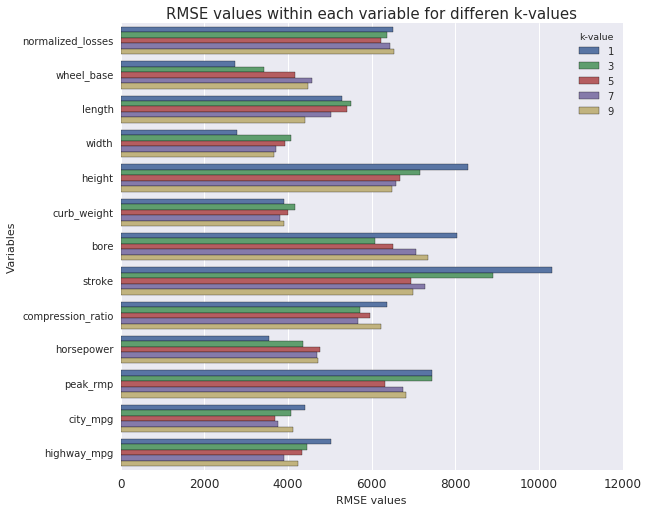

In [16]:
# Updating function
def knn_train_test(train, target, k, data):
    # Randomize data
    np.random.seed(1)
    data = data.loc[np.random.permutation(data.index)]
    # Split data to the training and test datasets
    train_set = data.iloc[:150]
    test_set = data.iloc[150:]
    # Instantiate KNeighborsRegressor class
    knn = KNeighborsRegressor(n_neighbors=k)
    # Fit the model
    knn.fit(train_set[[train]], train_set[[target]])
    # Make predictions
    labels = knn.predict(test_set[[train]])
    # Calculate mse
    mse = mean_squared_error(test_set['price'], labels)
    return mse**0.5

# Calculate RMSEs for each combination of variable and k
rmse_res = collections.defaultdict(list)
i = 0
for col in features:
    for k in [1, 3, 5, 7, 9]:
        rmse_res[i].extend([k, col,
                            knn_train_test(col,'price',
                                           k, cars_num)])
        i += 1
multi_k_result = pd.DataFrame.from_dict(rmse_res,
                                        orient='index')
multi_k_result.columns = ['k-value', 'variable', 'RMSE']

# Plot RMSEs values grouped by each variable
sns.set(rc={'figure.figsize':(9, 8)})
sns.barplot(x='RMSE', y='variable', hue='k-value',
            data=multi_k_result, orient='h')
plt.title('RMSE values within each variable for differen k-values',
         fontsize=15)
plt.xticks(rotation=0, fontsize=12)
plt.xlabel('RMSE values')
plt.ylabel('Variables')

## Experimenting with a multivariate model

We will update the definition of our function to work with several features. For this step, we will use one k-value which is 5. 

In [17]:
# Update the function
def knn_train_test(features, target, data, k=5):
    # Randomize data
    np.random.seed(1)
    data = data.loc[np.random.permutation(data.index)]
    
    # Split data to the training and test datasets
    train_set = data.iloc[:150]
    test_set = data.iloc[150:]
    # Instantiate KNeighborsRegressor class
    knn = KNeighborsRegressor(n_neighbors=k)
    # Fit the model
    knn.fit(train_set[features], train_set[target])
    # Make predictions
    labels = knn.predict(test_set[features])
    # Calculate mse
    mse = mean_squared_error(test_set[target], labels)
    return mse**0.5

# Find variables with lowest RMSE and k-value equal to 5
features = (multi_k_result.groupby('variable').mean()['RMSE']
               .sort_values().index.values)

# Calculate RMSE for different number of features
rmses_res ={}
for i in range(2, len(features) + 1):
    rmses_res[i] = knn_train_test(features[:i],
                                  'price', cars_num)

multivariate_result = pd.Series(rmses_res).sort_values()
multivariate_result

8     2246.254636
10    2354.434849
9     2414.644170
7     2423.487643
12    2489.879494
6     2513.599834
13    2624.277537
5     2709.547668
11    2712.175143
4     2792.801911
3     3120.289132
2     4582.186974
dtype: float64

We can observe that the lowest RMSE values are for 8, 10, and 9 number of features. We will now optimize the model with a given number of features and different values of k.

## Model optimization
   

In [19]:
# Compute RMSEs values for various combinations of k and 
# number of features
rmses_res = collections.defaultdict(list)
j = 0
for k in range(1, 26, 2):
    for i in [8, 9, 10]:
        rmses_res[j].extend([k, i, knn_train_test(
            features[:i], 'price', cars_num, k=k)])
        j += 1

optimization_result = pd.DataFrame.from_dict(
    rmses_res,
    orient='index'
)
optimization_result.columns = ['k-value', 'num_of_feat',
                               'RMSE']
optimization_result.sort_values('RMSE').head(10)

,k-value,num_of_feat,RMSE
6,5,8,2246.254636
5,3,10,2272.995113
8,5,10,2354.434849
11,7,10,2393.302320
7,5,9,2414.644170
13,9,9,2574.237428
0,1,8,2577.406570
2,1,10,2582.760577
3,3,8,2595.817898
10,7,9,2606.423557


## k-fold cross validation

In [21]:
# Upgrade the function definition
def cross_val(features, target, data, k=5, f=10):
    # Instantiating KFold class
    kf = KFold(f, shuffle=True, random_state=1)
    # Instantiate KNeighborsRegressor class
    knn = KNeighborsRegressor(n_neighbors=k)
    # Calculate mses
    mses = cross_val_score(knn, data[features], 
                          data[target],
                          scoring="neg_mean_squared_error",
                          cv=kf)
    rmses = np.mean(np.sqrt(np.abs(mses)))
    return round(rmses, 2)

rmses_res = collections.defaultdict(list)
j = 0
for k in range(1, 26, 2):
    for i in [8, 9, 10]:
        rmses_res[j].extend([
            k, i, cross_val(
                features[:i],
                'price',
                cars_num, k=k)])
        j += 1
cross_val_result = pd.DataFrame.from_dict(rmses_res,
                                             orient='index')
cross_val_result.columns = ['k-value', 'num_of_feat', 'RMSE']
cross_val_result.sort_values('RMSE').head(10)

,k-value,num_of_feat,RMSE
1,1,9,2882.59
2,1,10,2986.29
4,3,9,3003.24
0,1,8,3046.15
5,3,10,3066.97
3,3,8,3206.15
7,5,9,3448.02
8,5,10,3456.18
6,5,8,3457.85
11,7,10,3692.77


We can see that the result of cross-validation is very different. The best result is with k-value equal to 1 and the number of features equal to 9. Let's explore the data more deeply. We will compare the root mean squared errors and mean absolute errors. We will also add calculation of RMSEs standard deviation. 

## Comparing RMSE and MAE

In [23]:
# Updating function definition
def cross_val_mae_rmse(features, target, data, k=5, f=10):
    # Instantiating KFold class
    kf = KFold(f, shuffle=True, random_state=1)
    # Instantiate KNeighborsRegressor class
    knn = KNeighborsRegressor(n_neighbors=k)
    
    # Calculate mses
    mses = cross_val_score(knn, data[features], 
                          data[target],
                          scoring="neg_mean_squared_error",
                          cv=kf)
    # Calculate average rmse and rmse std
    avg_rmse = round(np.mean(np.sqrt(np.abs(mses))), 2)
    avr_rmse_std = round(np.std(np.sqrt(np.abs(mses))), 2)
    # Calculate average maes
    maes = cross_val_score(knn, data[features], 
                          data[target],
                          scoring="neg_mean_absolute_error",
                           cv=kf)
    avg_mae = round(np.mean(np.abs(maes)), 2)
    return [avg_mae, avg_rmse, avr_rmse_std]

# Exploring maes and rmses with various combination of
# k-value and features
res = collections.defaultdict(list)
j = 0
for k in range(1, 8, 2):
    for i in [8, 9, 10]:
        res[j].extend([
            k, i, cross_val_mae_rmse(
                features[:i],
                'price',
                cars_num, k=k)])
        j += 1
res

defaultdict(list,
            {0: [1, 8, [1899.38, 3046.15, 540.05]],
             1: [1, 9, [1979.11, 2882.59, 650.01]],
             2: [1, 10, [1968.35, 2986.29, 871.63]],
             3: [3, 8, [2074.46, 3206.15, 792.12]],
             4: [3, 9, [1938.63, 3003.24, 983.52]],
             5: [3, 10, [2050.73, 3066.97, 1076.0]],
             6: [5, 8, [2135.81, 3457.85, 1157.18]],
             7: [5, 9, [2145.21, 3448.02, 1300.16]],
             8: [5, 10, [2217.17, 3456.18, 1171.93]],
             9: [7, 8, [2311.48, 3747.79, 1243.49]],
             10: [7, 9, [2297.93, 3723.6, 1255.03]],
             11: [7, 10, [2271.97, 3692.77, 1221.16]]})

We can see that in the majority of case the MAE value is lower than the RMSE value. We can assume that there are some outliers in our data. We will now return to the database normalization step. This time we will standardize our data. 

In [24]:
# Create separate database
features = np.append(features[:10], 'price')
new_cars_num = cars[features].copy()

# Drop rows where price is nan
new_cars_num = new_cars_num.dropna(subset=['price'])
new_cars_num = new_cars_num.astype('float')
new_cars_num = new_cars_num.fillna(new_cars_num.mean())

# Standardize data
price = new_cars_num['price']
new_cars_num = ((new_cars_num - new_cars_num.mean()) /
                new_cars_num.std())
new_cars_num['price'] = price

# Looking for outliers
def find_outliers(data):
    res = {}
    for col in data.columns[:-1]:
        res[col] = data[col][
            (data[col] >=3) |
            (data[col] <=-3)
        ].shape[0]
    return res
find_outliers(new_cars_num)

NameError: name 'features_RMSE' is not defined

We can see that the most outliers in the compression_ration column. Let's remove the rows with outliers and observe the remaining ones. 

In [ ]:
# Remove rows with outliers
new_cars_num = new_cars_num[
            (new_cars_num['compression_ratio'] < 3) &
            (new_cars_num['compression_ratio'] > -3)]
# Check the number of outliers in each column
find_outliers(new_cars_num)

The number of outliers becomes smaller in the target column and in some other. We will now analyze the data using previously defined functions.

In [ ]:
# Calculate RMSEs using train/test validation
res = collections.defaultdict(list)
j = 0
for k in range(1, 10, 2):
    for i in [8, 9, 10]:
        res[j].extend([k, i, knn_train_test(
            features[:i], 'price', new_cars_num, k=k)])
        j += 1

train_test_result = pd.DataFrame.from_dict(res,
                                           orient='index')
train_test_result.columns = ['k-value', 'num_of_feat',
                             'RMSE']
train_test_result.sort_values('RMSE').head(10)

In [ ]:
# Calculate RMSEs using k-fold validation
res = collections.defaultdict(list)
j = 0
for k in range(1, 26, 2):
    for i in [8, 9, 10]:
        res[j].extend([
            k, i, cross_val(
                features[:i],
                'price',
                new_cars_num, k=k)])
        j += 1
kfold_result = pd.DataFrame.from_dict(rmses_res,
                                             orient='index')
kfold_result.columns = ['k-value', 'num_of_feat', 'RMSE']
kfold_result.sort_values('RMSE').head(10)

In [ ]:
# Looking at MAE/RMSE and RMSE std
res = collections.defaultdict(list)
j = 0
for k in range(1, 8, 2):
    for i in [8, 9, 10]:
        res[j].extend([
            k, i, cross_val_mae_rmse(
                features[:i],
                'price',
                new_cars_num, k=k)])
        j += 1
res

We can observe that:
-  train/test validation and k-fold validation return the same model parameters as the most efficient(k-value is 1, the number of parameters is 9). 
- this configuration of the model has the lowest values of average RMSE and standard deviation of RMSE (the bias/variance trade-off). 

But, the average MAE and average RMSE values are quite different, so we cannot say that the model is accurate.

## Conclusion

In this project, I practiced the fundamental Machine Learning workflow. k-nearest neighbors algorithm was used to build the model. I also used the train/test and k-fold validations and RMSE and MAE as metrics.

At this stage, we can conclude that the optimal k-value is 1 and the number of parameters is 9. But, this model needs further optimization.